<a href="https://colab.research.google.com/github/emjames/neural-networks/blob/master/classification/Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with movie reviews

This notebook mostly follows this [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/keras/basic_text_classification)

This is an example of binary classification.

## Objectives:
* Classify movie reviews as positive or negatives

Using the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) which contains 50,000 reviews split 50/50 for training and testing respectively.

In [1]:
# imports
# We're in py3 so we're in the future ... for now
# from __future__ import absoulte_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np

# plots
import matplotlib.pyplot as plt


print(tf.__version__)
!python --version

1.13.1
Python 3.6.7


# Fetch the dataset

In [0]:
imdb = keras.datasets.imdb

# keep the top 10,000 most frequently occurring words in the training data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


# Explore 

In [3]:
print("Training {}, labels: {}".format(len(train_data), len(train_labels)))
# Get the first n elements in the dataset
n = 5
print(train_data[:n])
print(train_labels[:n])


Training 25000, labels: 25000
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 19

In [0]:
# Plot the length of the data array
import matplotlib.pyplot as plt
#%matplotlib notebook

In [0]:
def plot_review_length_w_labels(data, labels, n=5, plot_title="No title"):
  # get the first N rows
  first_n = data[:n]

  # length of the first_n list
  first_n_length = [len(l) for l in first_n]

  dataset_count = np.arange(0,n)

  # green if the label is 1 (positive review), red otherwise 
  colors = [ 'g' if label == 1 else 'r' for label in labels[:n]]

  # make an array with the given shape filled with 'o'
  markers = np.full((n,), 'o')

  plt.clf() # clear figure
  # plot a dotted line to improve visualization
  plt.plot(dataset_count, first_n_length, 'b--')

  for x, y, color, mark in zip(dataset_count, first_n_length, colors, markers):
    plt.plot(x, y, c=color, marker=mark)
  
  plt.ylabel('List length')
  plt.xlabel('List index')
  plt.xticks(dataset_count)
  plt.title(plot_title)

  plt.show()

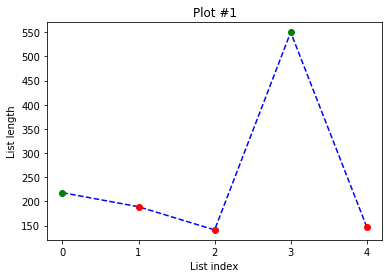

In [6]:
plot_review_length_w_labels(train_data, train_labels, plot_title="Plot #1")

Plot #1 shows the variation on the list length.  
Since inputs to a neural network must be the same length, we'll need to resolve this later

# Convert the integers back to words

In [0]:
# a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# the first indeces are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
# view a decoded review
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# Prepare the data
The reviews in integer form must be converted to tensors before fed into the NN. Two of the approaches:

  * Convert te arrays into vectors of 0s and 1s indicating word occurence (think one-hot encoding). Then, make this the first layer of our network - a Dense layer - that can handle floating point vector data. This is memory intensive, requiring a `numb_words * num_reviews` size matrix.
  * Pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in the network.
  
  We will use the second approach.
  
  Keras provides a [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function to standardize the lengths:

In [0]:
def pad_array(array, maxlen=256):
  return keras.preprocessing.sequence.pad_sequences(array,
                                                   value=word_index["<PAD>"],
                                                   padding='post',
                                                   maxlen=256)

train_data = pad_array(train_data)
test_data = pad_array(test_data)

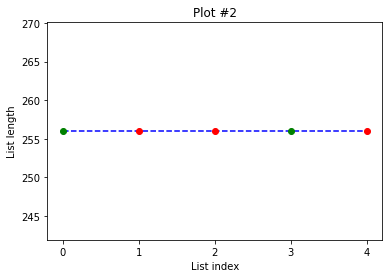

In [10]:
plot_review_length_w_labels(train_data, train_labels, plot_title="Plot #2")

# Build the model  

The NN is created by stacking layers -- this requires two main architectural decisions:
  * How many layers to use in the model?  
  * How many hidden units to use for each layer?  

On this dataset, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem.

The layers are stacked sequentially:
  1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The resulting dimensions are: `(batch, sequence, embedding)`
  2. The `GlobalAveragePooling1D` layer. Returns a fixed-length output vector for each example by averaging over the sequence dimension. Allow the model to handle input of variable length, in the simplest way possible.
  3. The fixed-length output vecotr is piped through a fully-connected (`Dense`) layer with 16 hidden units (more on this in the next section).
  4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 1nd 1, representing a probability, or confidence level.


In [11]:
# input shape is the vocabular count used for the move reviews (10k words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

More hidden units (higher-dimensional representation space), and/or more layers, the network can learn more complex representations. However, it makes the network more expensive and may lead to overfitting (i.e. learning unwanted patterns, memorizing the training data).

## Lost function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (last layer with sigmoid activation), we'll use the `binary_crossentropy` loss function.

We can also choose `mean_squared_error` but generally, `binary_crossentropy` is better for dealing with probabilites as it measures the "distance" between probability distributions, or in this case, distance between the ground-truth distribution and the predictions.

Now, configure the model to use an optimizer and a loss function:

In [0]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

# Create a validation set

A validation set helps to check the accuracy of the model on data it hasn't seen before. 

*Why not use the testing set now?* Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy.

In [0]:
validation_n = 10000

x_val = train_data[:validation_n]
partial_x_train = train_data[validation_n:]

y_val = train_labels[:validation_n]
partial_y_train = train_labels[validation_n:]

# Train the model

Train the model for 40 epocs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, **monitor the model's loss** and **accuracy** on the 10,000 samples from the validation set.

In [14]:
def train_model(epochs=40):
  return model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

history = train_model()

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.6916 - acc: 0.6036 - val_loss: 0.6889 - val_acc: 0.6741
Epoch 2/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6847 - acc: 0.7027 - val_loss: 0.6796 - val_acc: 0.7222
Epoch 3/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6706 - acc: 0.7433 - val_loss: 0.6622 - val_acc: 0.7433
Epoch 4/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6470 - acc: 0.7646 - val_loss: 0.6355 - val_acc: 0.7482
Epoch 5/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6132 - acc: 0.7930 - val_loss: 0.6004 - val_acc: 0.7835
Epoch 6/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.5712 - acc: 0.8157 - val_loss: 0.5601 - val_acc: 0.8106
Epoch 7/40
15000/15000 [==============================] - 1s 46us/sa

# Evaluate the model

Two values will be returned:
  1. Loss -- A number which represents our error (lower is better)
  2. Accuracy  

In [15]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 35us/sample - loss: 0.3339 - acc: 0.8719
[0.3339301110458374, 0.87188]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

# Plot he accuracy and loss over time

`model.fit()` returns a [`History`](https://keras.io/callbacks/#history) object that contains a dictionary with everything that happened during training.

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

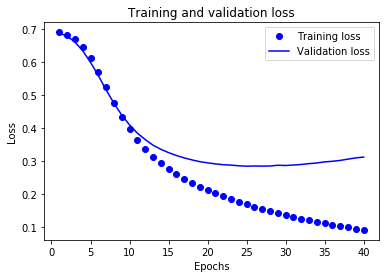

In [17]:
def plot_loss_epoch(history):

  loss = history['loss']
  val_loss = history['val_loss']
  
  epochs = range(1, len(loss) + 1)
  
  plt.clf() # clear figure
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.show()
  
plot_loss_epoch(history_dict)

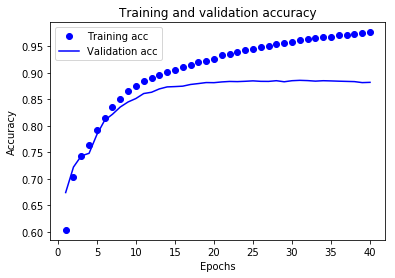

In [18]:
def plot_acc_epoch(history):
  
  acc = history['acc']
  val_acc = history['val_acc']
  
  epochs = range(1, len(acc) + 1)
  
  plt.clf() # clear figure
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.show()
  
plot_acc_epoch(history_dict)

Notice the training loss *decreses* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization -- it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy -- they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations to *specific* to the training data that do not *generalize* to test data.

For this case, we can prevent overfitting by simply stopping the training after twenty or so epochs.